In [27]:
# Import library yang diperlukan
import pandas as pd  # Untuk manipulasi data
import numpy as np   # Untuk operasi numerik
import matplotlib.pyplot as plt  # Untuk visualisasi dasar
import seaborn as sns  # Untuk visualisasi yang lebih advanced
from tabulate import tabulate  # Untuk menampilkan data dalam format tabel rapi
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# =============================================
# 1. KONFIGURASI AWAL DAN LOAD DATA
# =============================================
print("\n[1. KONFIGURASI AWAL DAN LOAD DATA]")

# Set style untuk visualisasi
sns.set_style("whitegrid")  # Set style untuk seaborn
plt.rcParams['figure.figsize'] = (12, 6)  # Set ukuran default figure

# Baca dataset
try:
    # Coba memuat dataset dari file CSV
    df = pd.read_csv('..\\DataSet\\world_population.csv')
    print("Dataset berhasil dimuat!")
except FileNotFoundError:
    # Jika file tidak ditemukan, tampilkan pesan error dan exit
    print("File tidak ditemukan. Pastikan nama file benar dan berada di direktori yang tepat.")
    exit()


[1. KONFIGURASI AWAL DAN LOAD DATA]
Dataset berhasil dimuat!


In [28]:
# =============================================
# 2. FUNGSI UTILITAS UNTUK MENAMPILKAN OUTPUT
# =============================================
print("\n[a. FUNGSI UTILITAS UNTUK DATA DALAM FORMAT TABEL RAPI]")

def display_table(title, data, headers=None):
    """
    Fungsi untuk menampilkan data dalam format tabel rapi.
    
    Parameters:
        title (str): Judul tabel
        data (DataFrame/list): Data yang akan ditampilkan
        headers (list): Header kolom (jika data bukan DataFrame)
    """
    print(f"\n=== {title.upper()} ===")
    if isinstance(data, pd.DataFrame):
        # Jika data adalah DataFrame, gunakan headers dari kolom DataFrame
        print(tabulate(data, headers='keys', tablefmt='psql', showindex=False))
    else:
        # Jika data bukan DataFrame, gunakan headers yang diberikan
        print(tabulate(data, headers=headers, tablefmt='psql'))


[a. FUNGSI UTILITAS UNTUK DATA DALAM FORMAT TABEL RAPI]


In [29]:
# =============================================
# 3. EKSPLORASI DATA AWAL - OUTPUT 1
# =============================================
print("\n[2. EKSPLORASI DATA AWAL]")

# Tampilkan 5 baris pertama data
display_table("5 Baris Pertama Data", df.head())

# Tampilkan daftar kolom yang tersedia
display_table("Nama Kolom yang Tersedia", pd.DataFrame(df.columns.tolist(), columns=['Kolom']))

# Buat DataFrame berisi informasi dasar dataset
info_data = pd.DataFrame({
    'Kolom': df.columns,
    'Tipe Data': df.dtypes.values,
    'Nilai Unik': df.nunique().values,
    'Nilai Hilang': df.isnull().sum().values
})
display_table("Informasi Dataset", info_data)

# Tampilkan statistik deskriptif untuk kolom numerik
display_table("Statistik Deskriptif (Numerik)", 
             df.describe().transpose().reset_index().rename(columns={'index': 'Kolom'}))



[2. EKSPLORASI DATA AWAL]

=== 5 BARIS PERTAMA DATA ===
+--------+---------------------------+---------------------+-----------------+--------------+--------------------+--------------------+------------------+--------------+------------+---------------+---------------+
|   Rank | Country (or dependency)   | Population (2024)   |   Yearly Change | Net Change   |   Density (P/km^2) | Land Area (Km^2)   | Migrants (net)   |   Fert. Rate |   Med. Age |   Urban Pop % |   World Share |
|--------+---------------------------+---------------------+-----------------+--------------+--------------------+--------------------+------------------+--------------+------------+---------------+---------------|
|      1 | India                     | 1,450,935,791       |            0.89 | 12,866,195   |                488 | 2,973,190          | -630,830         |          2   |         28 |            37 |         17.78 |
|      2 | China                     | 1,419,321,278       |           -0.23 | -3,2

In [30]:
# =============================================
# 4. ANALISIS MISSING VALUES - OUTPUT 2
# =============================================
print("\n[3. ANALISIS MISSING VALUES]")

# Hitung dan tampilkan missing values
missing_data = pd.DataFrame({
    'Kolom': df.isnull().sum().index,
    'Jumlah Missing': df.isnull().sum().values,
    'Persentase Missing': (df.isnull().sum() / len(df) * 100).round(2).values
}).query('`Jumlah Missing` > 0')  # Hanya tampilkan kolom dengan missing values

if not missing_data.empty:
    display_table("Nilai Hilang (Missing Values)", missing_data)
    
    # Berikan rekomendasi penanganan missing values
    recommendations = []
    for col in missing_data['Kolom']:
        if df[col].dtype in ['int64', 'float64']:
            rec = f"Isi dengan median ({df[col].median():.2f})"
        else:
            rec = "Isi dengan modus atau drop baris yang kosong"
        recommendations.append(rec)
    
    missing_data['Rekomendasi'] = recommendations
    display_table("Rekomendasi Penanganan Missing Values", missing_data)
else:
    print("\n=== NILAI HILANG (MISSING VALUES) ===")
    print("Tidak ada nilai hilang dalam dataset.")



[3. ANALISIS MISSING VALUES]

=== NILAI HILANG (MISSING VALUES) ===
Tidak ada nilai hilang dalam dataset.


In [31]:
# =============================================
# 5. ANALISIS DUPLIKAT - OUTPUT 3
# =============================================
print("\n[4. ANALISIS DUPLIKAT]")

# Hitung jumlah data duplikat
duplicates = df.duplicated().sum()
dup_data = pd.DataFrame({
    'Jumlah Duplikat': [duplicates],
    'Persentase Duplikat': [(duplicates / len(df) * 100).round(2)]
})
display_table("Cek Duplikat", dup_data)


[4. ANALISIS DUPLIKAT]

=== CEK DUPLIKAT ===
+-------------------+-----------------------+
|   Jumlah Duplikat |   Persentase Duplikat |
|-------------------+-----------------------|
|                 0 |                     0 |
+-------------------+-----------------------+


In [32]:
# =============================================
# 6. ANALISIS OUTLIER - OUTPUT 4
# =============================================
print("\n[5. ANALISIS OUTLIER]")

# Identifikasi kolom numerik untuk analisis outlier
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

outliers_data = []
for col in numerical_cols:
    # Hitung batas bawah dan atas dengan metode IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identifikasi outlier
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_pct = len(outliers)/len(df)*100
    
    # Simpan hasil analisis
    outliers_data.append({
        'Kolom': col,
        'Batas Bawah': f"{lower_bound:.2f}",
        'Batas Atas': f"{upper_bound:.2f}",
        'Jumlah Outlier': len(outliers),
        'Persentase Outlier': f"{outliers_pct:.2f}%"
    })

# Tampilkan hasil analisis outlier dalam tabel
outliers_df = pd.DataFrame(outliers_data)
display_table("Analisis Outlier", outliers_df)


[5. ANALISIS OUTLIER]

=== ANALISIS OUTLIER ===
+---------------+---------------+--------------+------------------+----------------------+
| Kolom         |   Batas Bawah |   Batas Atas |   Jumlah Outlier | Persentase Outlier   |
|---------------+---------------+--------------+------------------+----------------------|
| Rank          |       -114.5  |       339.5  |                0 | 0.00%                |
| Yearly Change |         -2.45 |         4.56 |                5 | 2.31%                |
| Fert. Rate    |         -0.94 |         5.56 |                5 | 2.31%                |
| Med. Age      |         -3.5  |        64.5  |                0 | 0.00%                |
| Urban Pop %   |        -15.62 |       137.38 |                0 | 0.00%                |
| World Share   |         -0.46 |         0.79 |               23 | 10.65%               |
+---------------+---------------+--------------+------------------+----------------------+



[6. VISUALISASI DATA]
=> Plot akan ditampilkan dalam window terpisah...


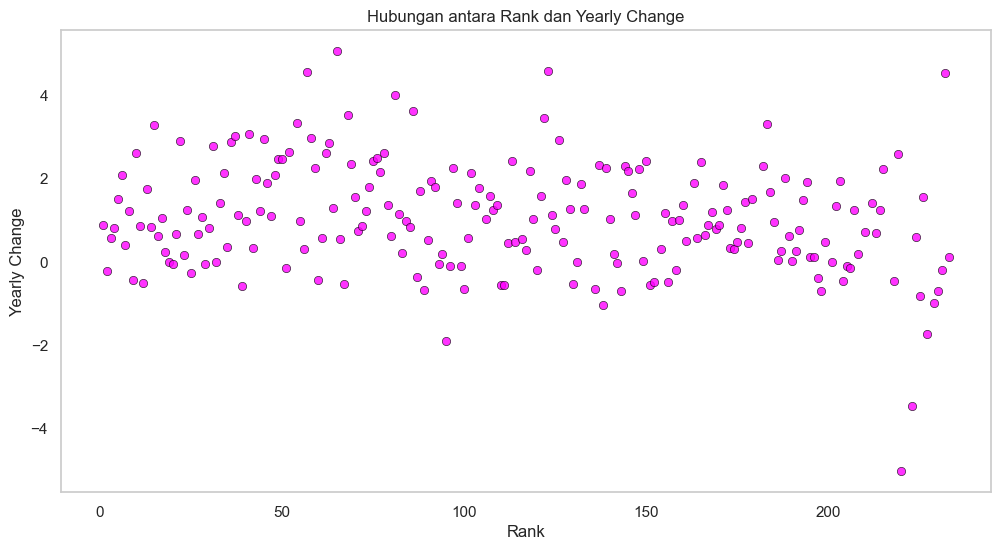

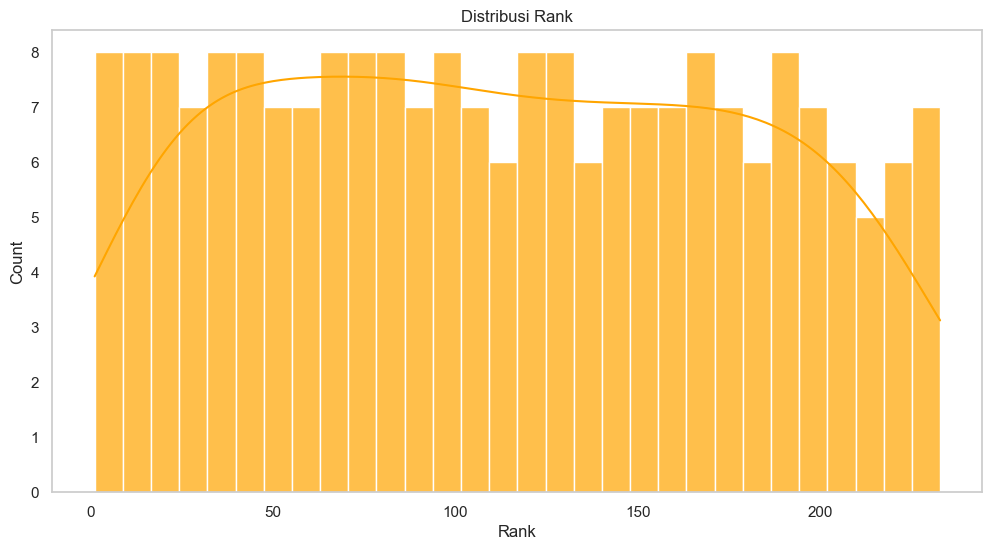

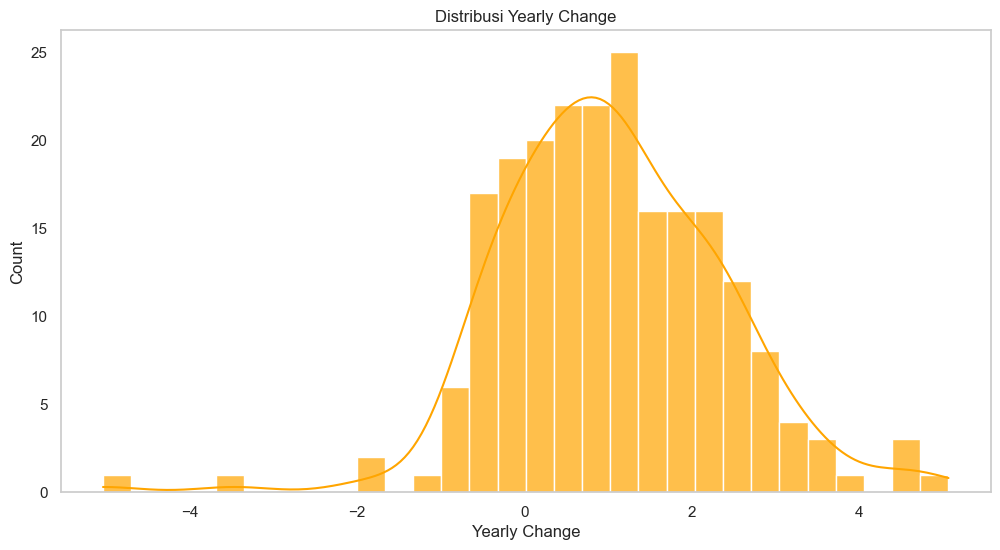

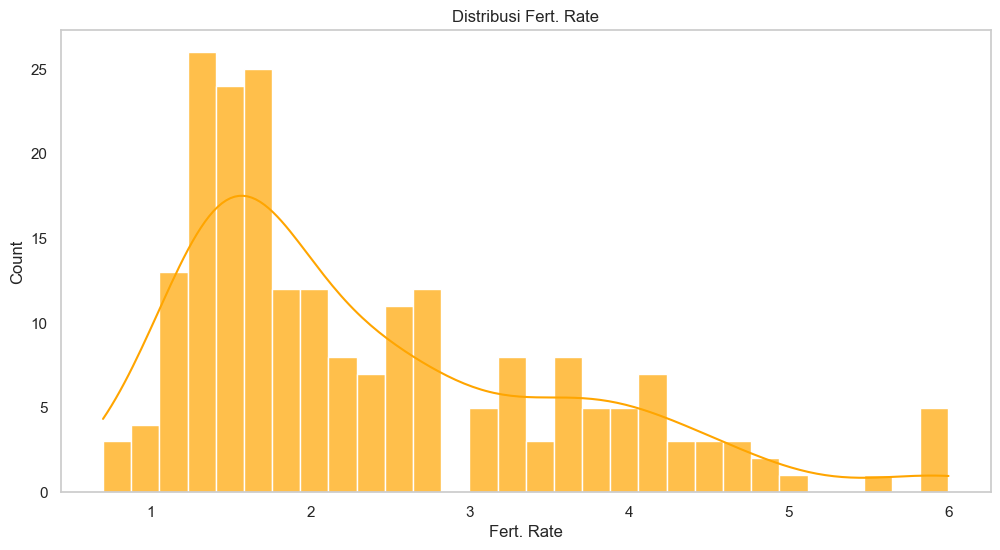

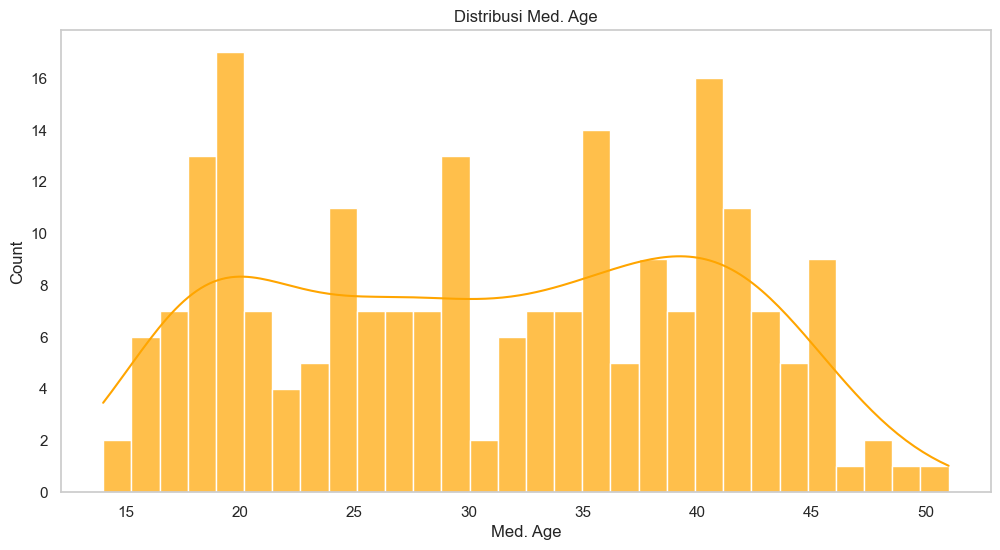

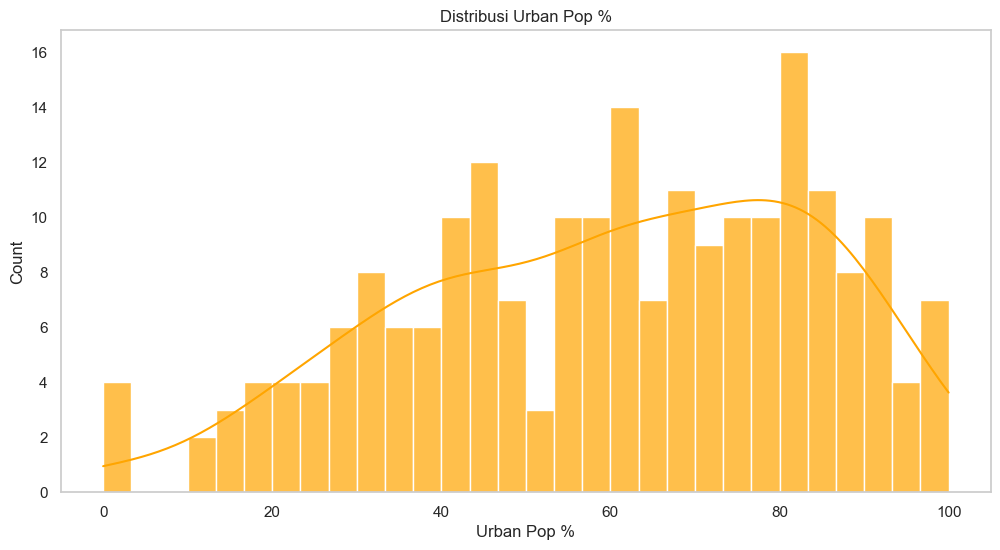

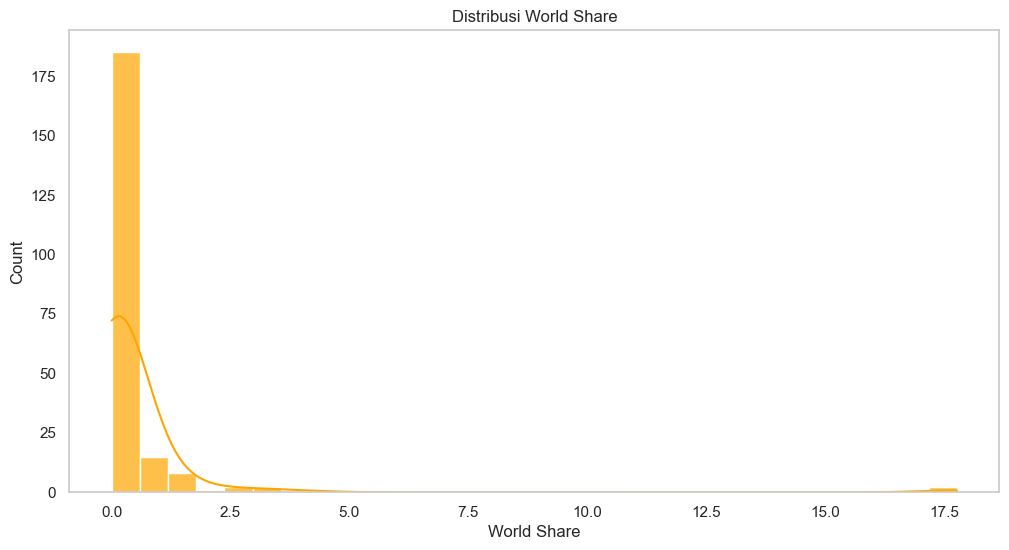

In [33]:
# Set style dan hilangkan background putih
sns.set(style="whitegrid")
plt.rcParams['savefig.transparent'] = True  # Jika ingin menyimpan gambar
plt.rcParams['figure.facecolor'] = 'none'   # Transparan background figure
plt.rcParams['axes.facecolor'] = 'none'     # Transparan background axes

print("\n[6. VISUALISASI DATA]")
print("=> Plot akan ditampilkan dalam window terpisah...")

# 1. Scatter plot untuk hubungan antara dua kolom numerik pertama
if len(numerical_cols) >= 2:
    try:
        plt.figure(figsize=(12, 6))
        sns.scatterplot(x=numerical_cols[0], y=numerical_cols[1], data=df,
                        color='magenta', alpha=0.8, edgecolor='black')
        plt.title(f'Hubungan antara {numerical_cols[0]} dan {numerical_cols[1]}')
        plt.grid(False)
        plt.show()
    except Exception as e:
        print(f"\nTidak dapat membuat scatter plot: {e}")

# 2. Histogram untuk distribusi kolom numerik
for col in numerical_cols:
    try:
        plt.figure(figsize=(12, 6))
        sns.histplot(df[col], bins=30, kde=True, color='orange', alpha=0.7)
        plt.title(f'Distribusi {col}')
        plt.grid(False)
        plt.show()
    except Exception as e:
        print(f"\nTidak dapat membuat histogram untuk {col}: {e}")

# 3. Count plot untuk kolom kategorikal
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    try:
        if len(df[col].unique()) <= 20:
            plt.figure(figsize=(12, 6))
            sns.countplot(y=col, data=df, order=df[col].value_counts().index,
                        palette='Set1', alpha=0.85)
            plt.title(f'Distribusi {col}')
            plt.grid(False)
            plt.show()
    except Exception as e:
        print(f"\nTidak dapat membuat count plot untuk {col}: {e}")

In [34]:
# =============================================
# 8. KESIMPULAN EDA - OUTPUT 6
# =============================================
print("\n[7. KESIMPULAN EDA]")

# Siapkan data untuk tabel kesimpulan
conclusion_data = [
    ["1. Statistik Dasar", f"{len(df)} baris, {len(df.columns)} kolom"],
    ["2. Masalah yang Teridentifikasi", ""],
    ["- Nilai hilang", f"{missing_data['Jumlah Missing'].sum() if not missing_data.empty else 0} total"],
    ["- Duplikat", f"{duplicates} baris"],
    ["- Outlier", "Terdeteksi pada beberapa kolom numerik (lihat tabel outlier)"],
    ["3. Rekomendasi", ""],
    ["- Missing Values", "Tangani sesuai rekomendasi di tabel missing values"],
    ["- Outlier", "Pertimbangkan untuk menghapus atau menangani outlier"],
    ["- Analisis Lanjutan", "Lakukan analisis lebih dalam berdasarkan visualisasi"]
]

# Tampilkan tabel kesimpulan
display_table("Ringkasan Kesimpulan", conclusion_data, headers=["Kategori", "Deskripsi"])


[7. KESIMPULAN EDA]

=== RINGKASAN KESIMPULAN ===
+---------------------------------+--------------------------------------------------------------+
| Kategori                        | Deskripsi                                                    |
|---------------------------------+--------------------------------------------------------------|
| 1. Statistik Dasar              | 216 baris, 12 kolom                                          |
| 2. Masalah yang Teridentifikasi |                                                              |
| - Nilai hilang                  | 0 total                                                      |
| - Duplikat                      | 0 baris                                                      |
| - Outlier                       | Terdeteksi pada beberapa kolom numerik (lihat tabel outlier) |
| 3. Rekomendasi                  |                                                              |
| - Missing Values                | Tangani sesuai rekomen


=> 9.1. ANALISIS KORELASI ANTAR VARIABEL <=


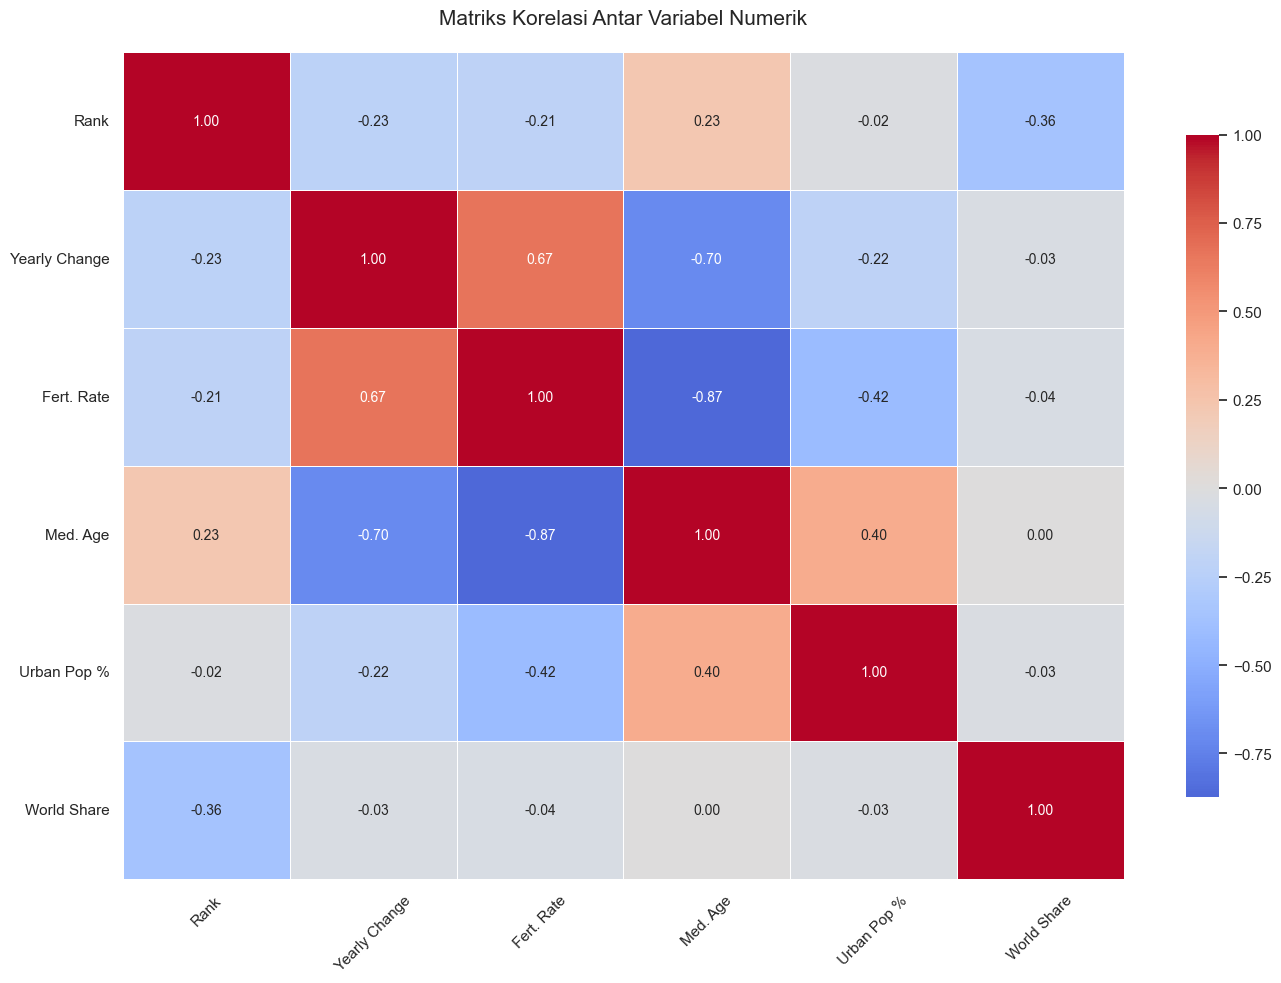


=== PASANGAN VARIABEL DENGAN KORELASI KUAT (|R| > 0.7) ===
+--------------+--------------+----------------------+
| Variabel 1   | Variabel 2   |   Koefisien Korelasi |
|--------------+--------------+----------------------|
| Fert. Rate   | Med. Age     |            -0.872013 |
| Med. Age     | Fert. Rate   |            -0.872013 |
+--------------+--------------+----------------------+


In [35]:
# --------------------------------------------------
# 9.1. Analisis Korelasi Antar Variabel <—
# --------------------------------------------------
print("\n=> 9.1. ANALISIS KORELASI ANTAR VARIABEL <=")

# Hitung matriks korelasi
corr_matrix = df.select_dtypes(include=['int64','float64']).corr()

# Set style untuk menghilangkan background putih
sns.set(style='white')

# Visualisasi heatmap korelasi
plt.figure(figsize=(14,10))
sns.heatmap(
    corr_matrix, 
    annot=True, 
    cmap='coolwarm', 
    center=0, 
    fmt=".2f", 
    linewidths=0.5, 
    annot_kws={"size":10},
    cbar_kws={'shrink': 0.8}
)

# Menghilangkan grid dan background putih
plt.title('Matriks Korelasi Antar Variabel Numerik', pad=20, fontsize=15)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.grid(False)  # Menghilangkan garis grid
plt.tight_layout()
plt.show()

# Identifikasi korelasi kuat
strong_corr = corr_matrix.unstack().sort_values(ascending=False)
strong_corr = strong_corr[(abs(strong_corr) > 0.7) & (strong_corr < 1)]

if not strong_corr.empty:
    display_table(
        "Pasangan Variabel dengan Korelasi Kuat (|r| > 0.7)", 
        pd.DataFrame(strong_corr.reset_index()).rename(columns={
            'level_0': 'Variabel 1',
            'level_1': 'Variabel 2',
            0: 'Koefisien Korelasi'
        })
    )
else:
    print("Tidak ditemukan korelasi kuat (|r| > 0.7) antar variabel")


In [36]:
def classify_population(pop):
    if pop >= 1e9:
        return "Very High"
    elif pop >= 100_000_000:
        return "High"
    elif pop >= 10_000_000:
        return "Medium"
    else:
        return "Low"

df["Pop_Category"] = df["Population (2024)"].str.replace(",", "").astype(int).apply(classify_population)
def is_valid_numeric(col):
    """Cek apakah kolom numerik memiliki lebih dari satu nilai unik (bukan konstanta)."""
    return pd.api.types.is_numeric_dtype(df[col]) and df[col].nunique() > 1



=> 9.2. ANALISIS SEGMENTASI BERDASARKAN KATEGORI <==


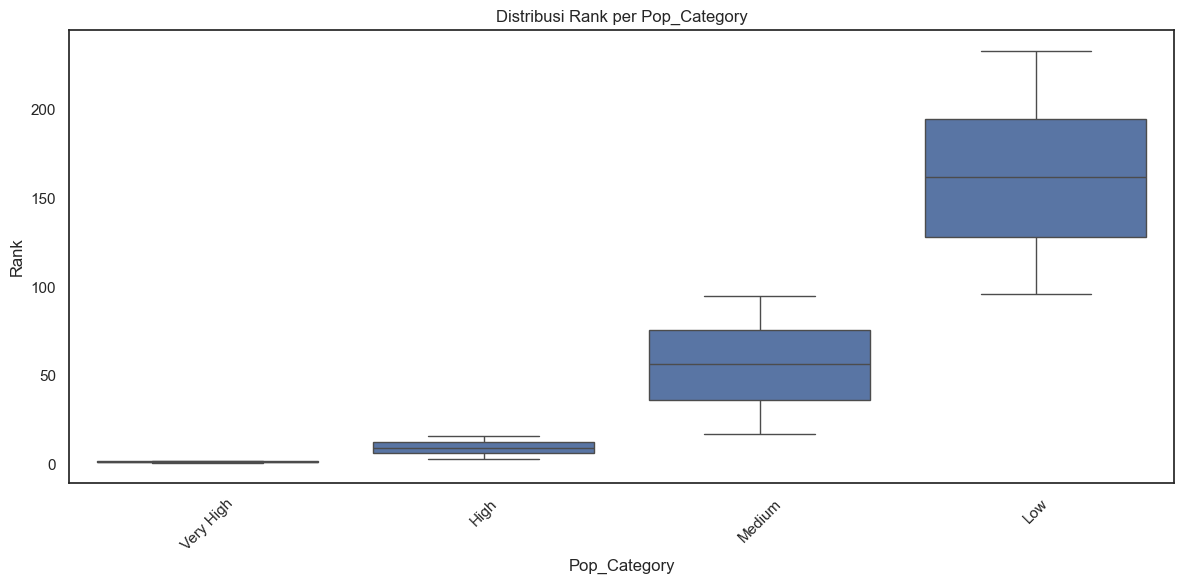


=== STATISTIK RANK PER POP_CATEGORY ===
+----------------+---------+----------+-----------+-------+--------+-------+--------+-------+
| Pop_Category   |   count |     mean |       std |   min |    25% |   50% |    75% |   max |
|----------------+---------+----------+-----------+-------+--------+-------+--------+-------|
| High           |      14 |   9.5    |  4.1833   |     3 |   6.25 |   9.5 |  12.75 |    16 |
| Low            |     122 | 162.393  | 39.4873   |    96 | 128.25 | 162   | 194.75 |   233 |
| Medium         |      78 |  56.0385 | 23.0952   |    17 |  36.25 |  56.5 |  75.75 |    95 |
| Very High      |       2 |   1.5    |  0.707107 |     1 |   1.25 |   1.5 |   1.75 |     2 |
+----------------+---------+----------+-----------+-------+--------+-------+--------+-------+


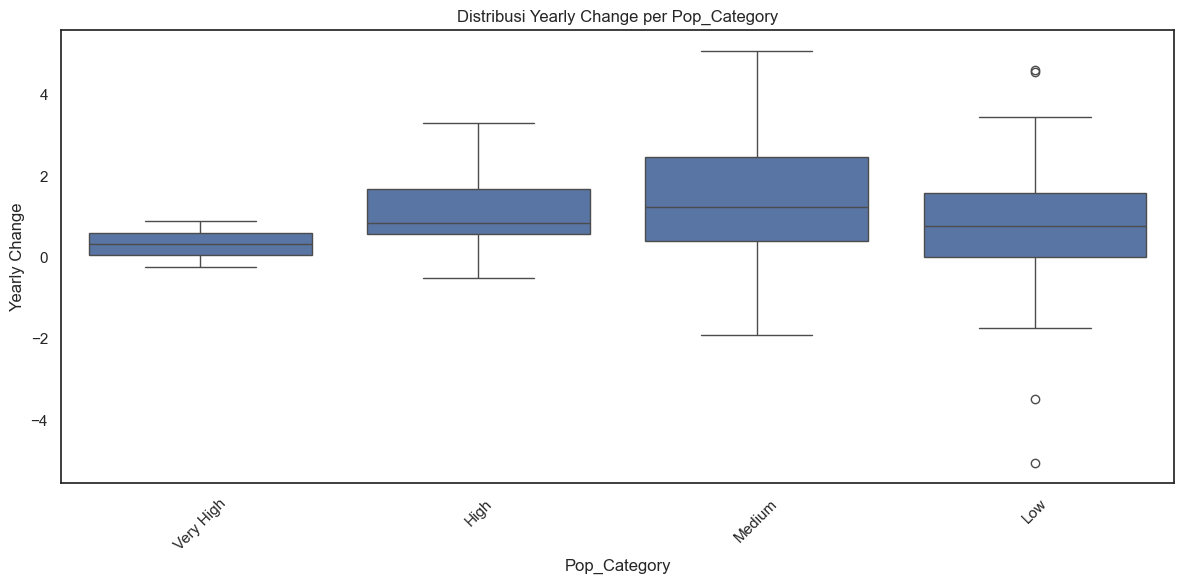


=== STATISTIK YEARLY CHANGE PER POP_CATEGORY ===
+----------------+---------+----------+---------+-------+-------+-------+--------+-------+
| Pop_Category   |   count |     mean |     std |   min |   25% |   50% |    75% |   max |
|----------------+---------+----------+---------+-------+-------+-------+--------+-------|
| High           |      14 | 1.12143  | 1.06861 | -0.5  | 0.585 | 0.845 | 1.6925 |  3.3  |
| Low            |     122 | 0.813361 | 1.30488 | -5.04 | 0.015 | 0.785 | 1.5825 |  4.6  |
| Medium         |      78 | 1.42256  | 1.33259 | -1.9  | 0.395 | 1.23  | 2.4575 |  5.07 |
| Very High      |       2 | 0.33     | 0.79196 | -0.23 | 0.05  | 0.33  | 0.61   |  0.89 |
+----------------+---------+----------+---------+-------+-------+-------+--------+-------+


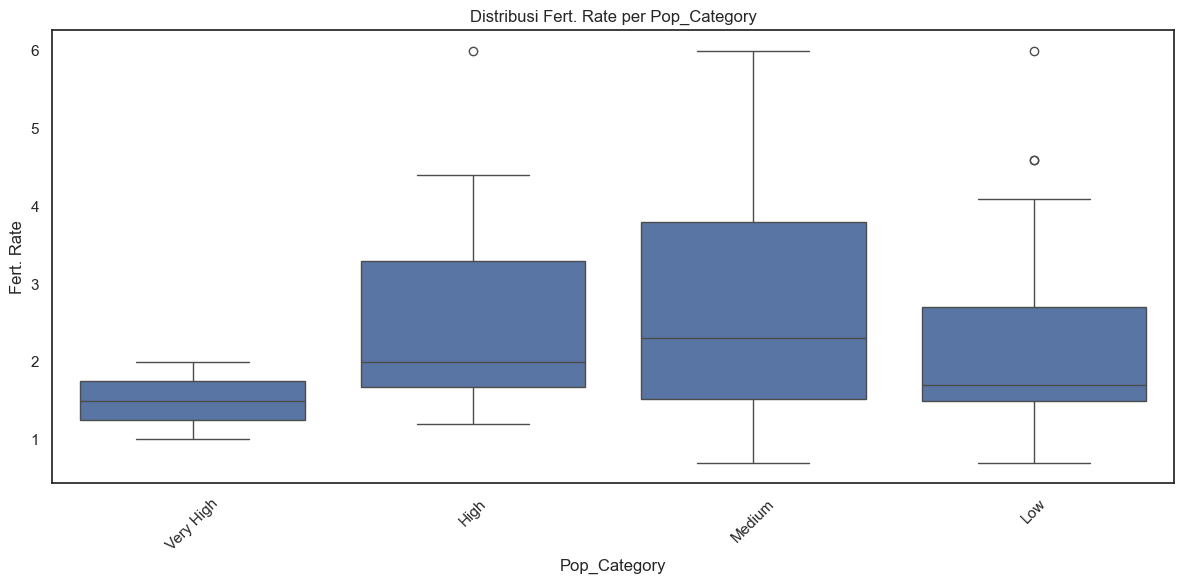


=== STATISTIK FERT. RATE PER POP_CATEGORY ===
+----------------+---------+---------+----------+-------+-------+-------+-------+-------+
| Pop_Category   |   count |    mean |      std |   min |   25% |   50% |   75% |   max |
|----------------+---------+---------+----------+-------+-------+-------+-------+-------|
| High           |      14 | 2.59286 | 1.37139  |   1.2 | 1.675 |   2   |  3.3  |     6 |
| Low            |     122 | 2.15984 | 0.967886 |   0.7 | 1.5   |   1.7 |  2.7  |     6 |
| Medium         |      78 | 2.71026 | 1.3842   |   0.7 | 1.525 |   2.3 |  3.8  |     6 |
| Very High      |       2 | 1.5     | 0.707107 |   1   | 1.25  |   1.5 |  1.75 |     2 |
+----------------+---------+---------+----------+-------+-------+-------+-------+-------+


In [37]:
# --------------------------------------------------
# 9.2. Analisis Segmentasi Berdasarkan Kategori
# --------------------------------------------------
print("\n=> 9.2. ANALISIS SEGMENTASI BERDASARKAN KATEGORI <==")

categorical_cols = df.select_dtypes(include=['object']).columns
valid_categories = [col for col in categorical_cols 
                   if 2 <= df[col].nunique() <= 10]

if valid_categories:
    for category in valid_categories:
        numerical_for_analysis = [col for col in numerical_cols 
                                if col != category and is_valid_numeric(col)]
        
        if numerical_for_analysis:
            for target_var in numerical_for_analysis[:3]:  # Batasi 3 variabel
                # Visualisasi boxplot
                plt.figure(figsize=(12,6))
                sns.boxplot(x=category, y=target_var, data=df)
                plt.title(f'Distribusi {target_var} per {category}')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()
                
                # Statistik deskriptif
                stats = df.groupby(category)[target_var].describe()
                display_table(
                    f"Statistik {target_var} per {category}", 
                    stats.reset_index()
                )
else:
    print("Tidak ditemukan kolom kategorikal yang cocok untuk segmentasi (2-10 kategori unik)")


=> 9.3. ANALISIS OUTLIER MENDALAM <==


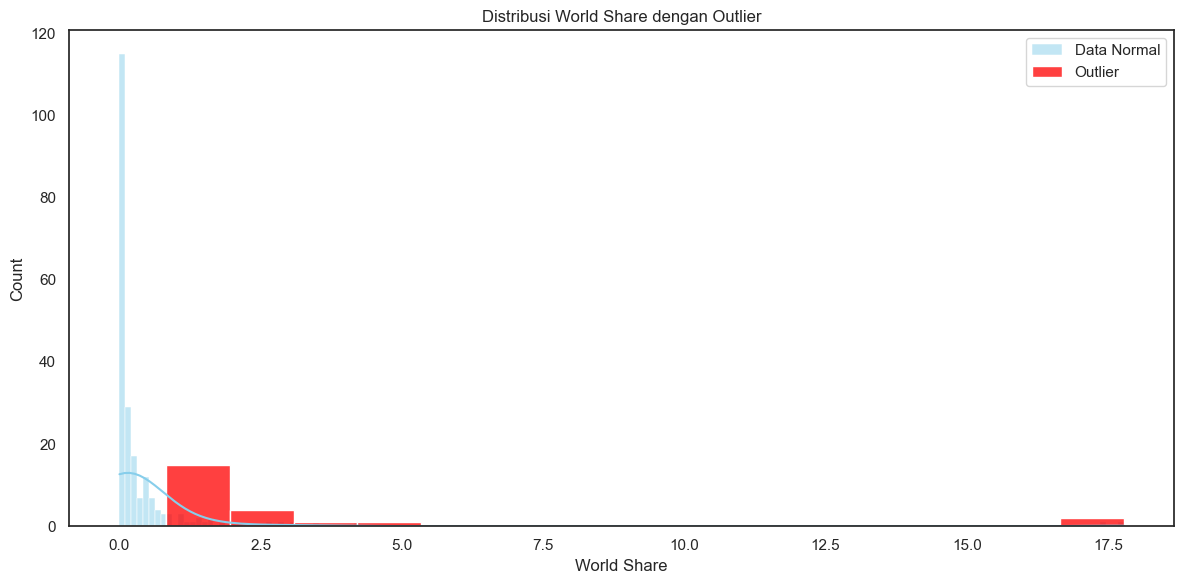


=== STATISTIK OUTLIER VS NON-OUTLIER WORLD SHARE ===
+-------------+-------------+----------+----------+
| Tipe        |   Rata-rata |   Median |   Jumlah |
|-------------+-------------+----------+----------|
| Outlier     |    3.13435  |     1.52 |       23 |
| Non-Outlier |    0.141088 |     0.06 |      193 |
+-------------+-------------+----------+----------+


In [38]:
# --------------------------------------------------
# 9.3. Analisis Outlier Mendalam
# --------------------------------------------------
print("\n=> 9.3. ANALISIS OUTLIER MENDALAM <==")

significant_outliers = outliers_df[
    outliers_df['Persentase Outlier'].str.replace('%','').astype(float) > 5
]

if not significant_outliers.empty:
    for _, row in significant_outliers.iterrows():
        col = row['Kolom']
        
        # Visualisasi distribusi
        plt.figure(figsize=(12,6))
        sns.histplot(df[col], kde=True, color='skyblue', label='Data Normal')
        
        # Identifikasi outlier
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[col] < (Q1 - 1.5*IQR)) | (df[col] > (Q3 + 1.5*IQR))]
        
        if not outliers.empty:
            sns.histplot(outliers[col], color='red', label='Outlier')
            plt.legend()
            plt.title(f'Distribusi {col} dengan Outlier')
            plt.tight_layout()
            plt.show()
            
            # Statistik komparatif
            stats = pd.DataFrame({
                'Tipe': ['Outlier', 'Non-Outlier'],
                'Rata-rata': [
                    outliers[col].mean(), 
                    df[~df.index.isin(outliers.index)][col].mean()
                ],
                'Median': [
                    outliers[col].median(), 
                    df[~df.index.isin(outliers.index)][col].median()
                ],
                'Jumlah': [len(outliers), len(df)-len(outliers)]
            })
            display_table(f"Statistik Outlier vs Non-Outlier {col}", stats)
else:
    print("Tidak ditemukan kolom dengan outlier signifikan (>5% data)")


=> 9.4. ANALISIS TIME SERIES <==


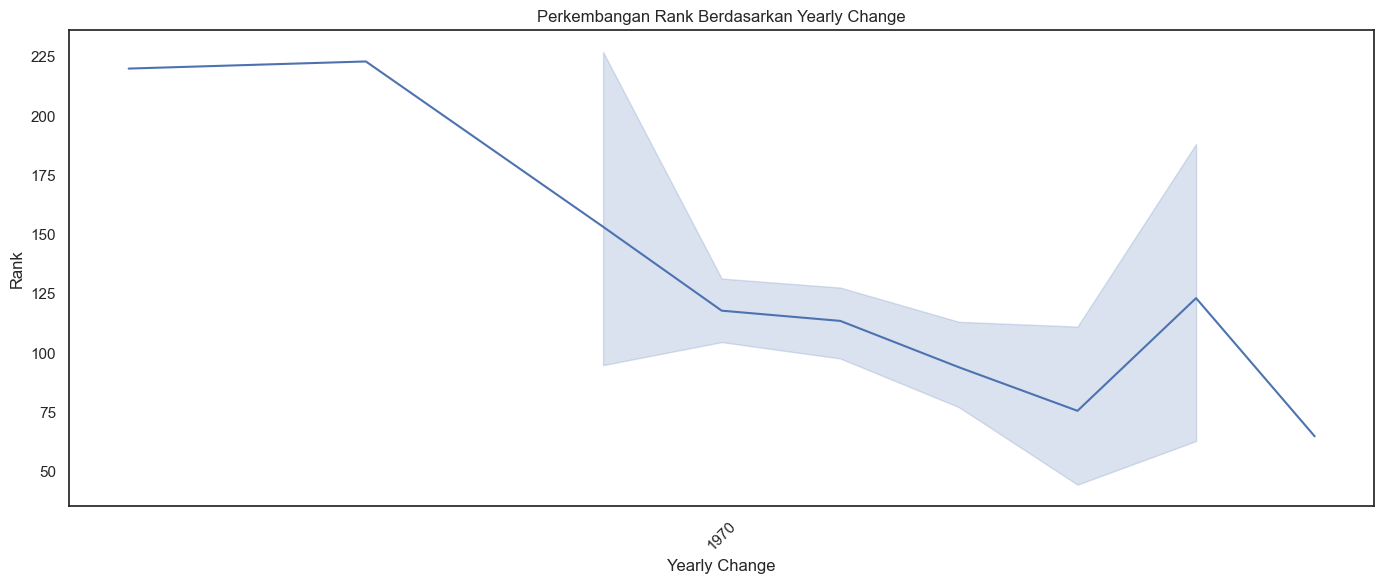

,Period,mean,median,std
0,1969,180.600000,220.0,60.508677
1,1970,110.976303,109.0,66.086915


In [39]:
# --------------------------------------------------
# 9.4. Analisis Time Series
# --------------------------------------------------
print("\n=> 9.4. ANALISIS TIME SERIES <==")

# Identifikasi kolom waktu
potential_time_cols = [
    col for col in df.columns 
    if any(keyword in col.lower() for keyword in ['date', 'year', 'time', 'tanggal'])
]

if potential_time_cols:
    time_col = potential_time_cols[0]  # ambil kolom waktu pertama
    
    try:
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        df = df.dropna(subset=[time_col])  # buang baris dengan waktu kosong

        # Pastikan kolom numerik tersedia dan tidak kosong
        valid_numeric = [
            col for col in numerical_cols 
            if pd.api.types.is_numeric_dtype(df[col]) and df[col].notna().sum() > 1
        ]

        if valid_numeric:
            num_var = valid_numeric[0]

            # Sort berdasarkan waktu
            df = df.sort_values(by=time_col)

            # Plot time series
            plt.figure(figsize=(14,6))
            sns.lineplot(x=time_col, y=num_var, data=df)
            plt.title(f'Perkembangan {num_var} Berdasarkan {time_col}')
            plt.xlabel(time_col)
            plt.ylabel(num_var)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

            # Statistik periodik
            df['Period'] = df[time_col].dt.to_period('Y')
            period_stats = df.groupby('Period')[num_var].agg(['mean', 'median', 'std'])
            display(period_stats.reset_index().head(10))  # tampilkan sebagian
        else:
            print("Tidak ada kolom numerik yang cocok untuk time series.")
    except Exception as e:
        print(f"Gagal memproses kolom waktu {time_col}: {str(e)}")
else:
    print("Tidak ditemukan kolom waktu yang cocok dalam data.")



=> 9.5. ANALISIS REDUKSI DIMENSI <===


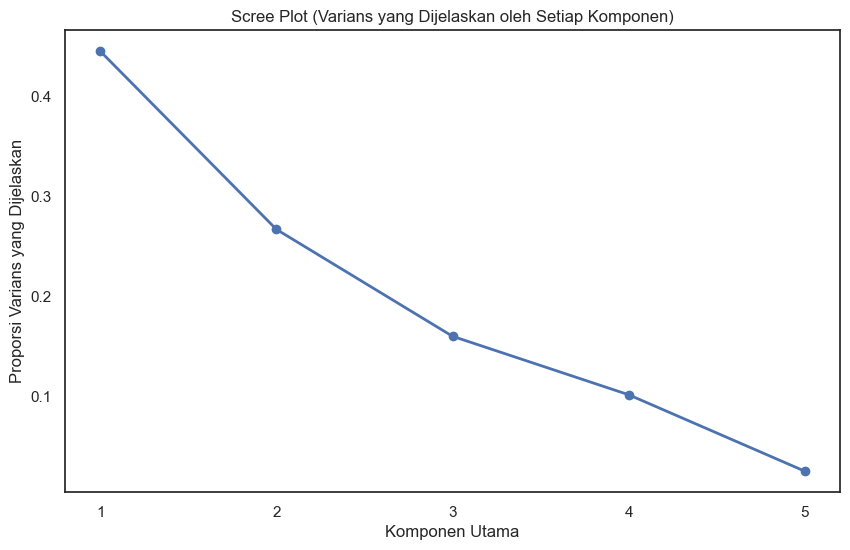

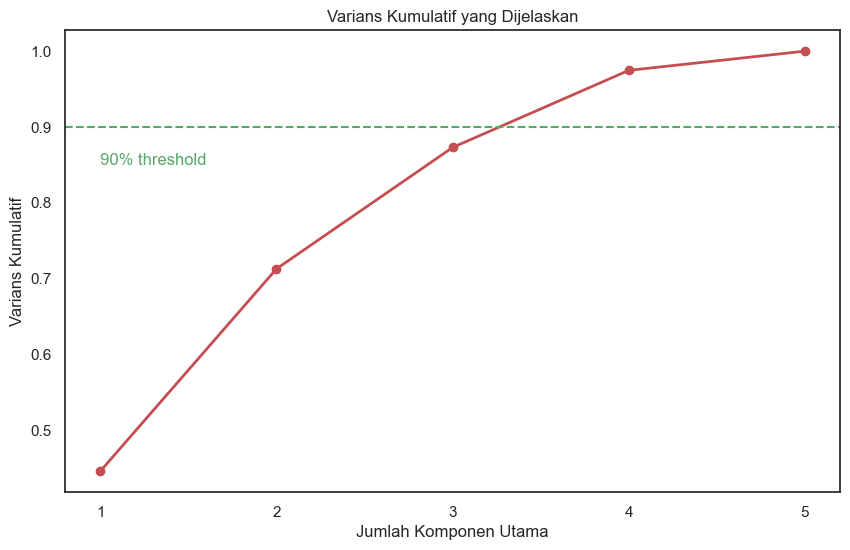

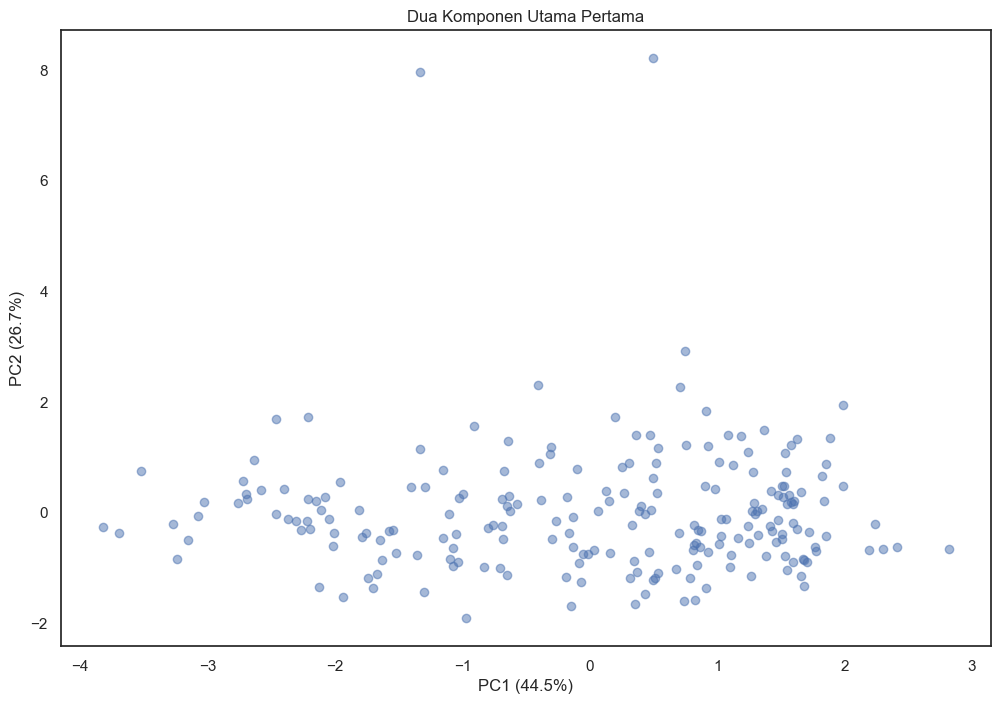

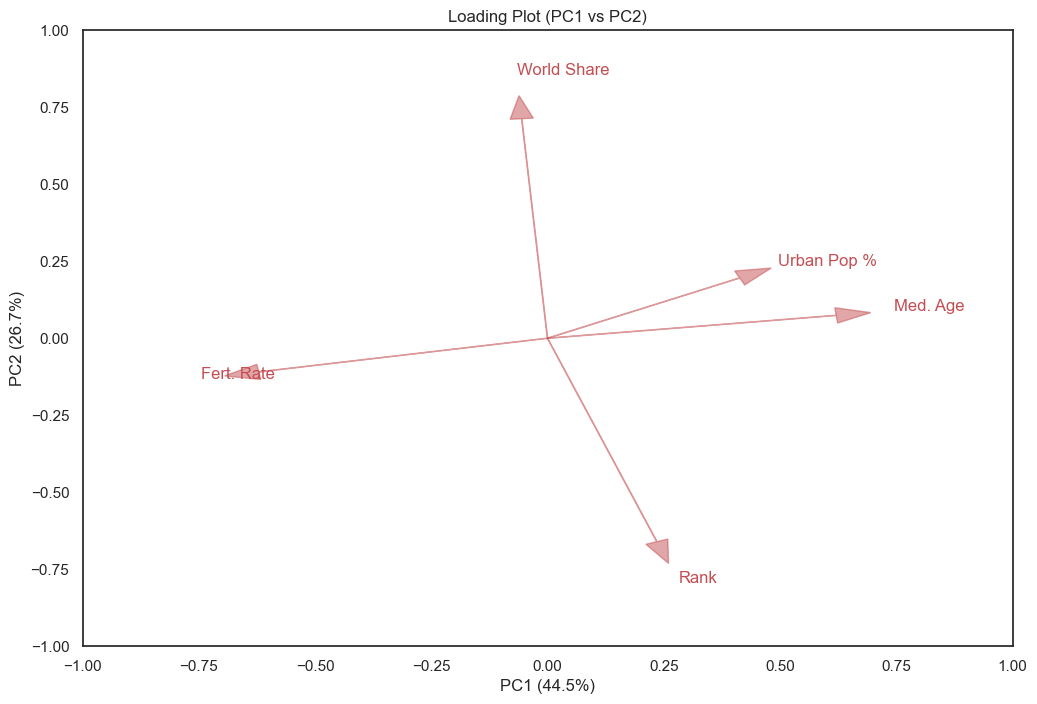


Hasil Analisis PCA:
Total varians yang dijelaskan oleh 2 komponen pertama: 71.26%

Komposisi Komponen Utama:
+-------------+-----------+------------+-----------+-----------+------------+
|             |       PC1 |        PC2 |       PC3 |       PC4 |        PC5 |
|-------------+-----------+------------+-----------+-----------+------------|
| Rank        |  0.235178 | -0.660437  | -0.347492 |  0.622659 | 0.00775744 |
| Fert. Rate  | -0.620811 | -0.109289  |  0.209902 |  0.22683  | 0.712137   |
| Med. Age    |  0.620824 |  0.0742642 | -0.202601 | -0.277512 | 0.700715   |
| Urban Pop % |  0.413264 |  0.195746  |  0.753598 |  0.471875 | 0.0178814  |
| World Share | -0.055455 |  0.712775  | -0.47564  |  0.511043 | 0.0384604  |
+-------------+-----------+------------+-----------+-----------+------------+


In [40]:
# --------------------------------------------------
# 9.5. Analisis Dimensi dengan PCA
# --------------------------------------------------
print("\n=> 9.5. ANALISIS REDUKSI DIMENSI <===")

# First, let's define the helper function
def is_valid_numeric(col):
    """Check if a column is valid for PCA analysis"""
    return pd.api.types.is_numeric_dtype(df[col]) and not df[col].isnull().all()

# Get numerical columns from the dataframe
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

# Filter valid numerical columns
valid_numerical_cols = [col for col in numerical_cols if is_valid_numeric(col)]

if len(valid_numerical_cols) >= 3:
    try:
        # Prepare data for PCA
        X = df[valid_numerical_cols].dropna()
        
        # Standardize the data
        scaler = StandardScaler()
        X_std = scaler.fit_transform(X)
        
        # Perform PCA
        pca = PCA()
        principal_components = pca.fit_transform(X_std)
        
        # Create a DataFrame with the principal components
        pca_df = pd.DataFrame(data=principal_components, 
                             columns=[f'PC{i+1}' for i in range(len(valid_numerical_cols))])
        
        # Add country names if available
        if 'Country' in df.columns:
            pca_df['Country'] = df.loc[X.index, 'Country']
        
        # 1. Scree Plot (Variances)
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
                pca.explained_variance_ratio_, 
                'bo-', 
                linewidth=2)
        plt.title('Scree Plot (Varians yang Dijelaskan oleh Setiap Komponen)')
        plt.xlabel('Komponen Utama')
        plt.ylabel('Proporsi Varians yang Dijelaskan')
        plt.xticks(range(1, len(pca.explained_variance_ratio_)+1))
        plt.show()
        
        # 2. Cumulative Variance Plot
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(pca.explained_variance_ratio_)+1), 
                np.cumsum(pca.explained_variance_ratio_), 
                'ro-', 
                linewidth=2)
        plt.title('Varians Kumulatif yang Dijelaskan')
        plt.xlabel('Jumlah Komponen Utama')
        plt.ylabel('Varians Kumulatif')
        plt.axhline(y=0.9, color='g', linestyle='--')
        plt.text(1, 0.85, '90% threshold', color='g')
        plt.xticks(range(1, len(pca.explained_variance_ratio_)+1))
        plt.show()
        
        # 3. First Two Principal Components
        plt.figure(figsize=(12, 8))
        plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
        plt.title('Dua Komponen Utama Pertama')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        
        # Add country labels if available
        if 'Country' in pca_df.columns:
            for i, txt in enumerate(pca_df['Country']):
                plt.annotate(txt, (principal_components[i, 0], principal_components[i, 1]))
        
        plt.show()
        
        # 4. Loading Plot
        plt.figure(figsize=(12, 8))
        for i, feature in enumerate(valid_numerical_cols):
            plt.arrow(0, 0, 
                     pca.components_[0, i], 
                     pca.components_[1, i],
                     color='r', 
                     alpha=0.5,
                     head_width=0.05)
            plt.text(pca.components_[0, i]*1.2, 
                    pca.components_[1, i]*1.2, 
                    feature, 
                    color='r')
        
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.title('Loading Plot (PC1 vs PC2)')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.show()
        
        # Print PCA results
        print("\nHasil Analisis PCA:")
        print(f"Total varians yang dijelaskan oleh 2 komponen pertama: {np.sum(pca.explained_variance_ratio_[:2])*100:.2f}%")
        print("\nKomposisi Komponen Utama:")
        loadings = pd.DataFrame(pca.components_.T, 
                               columns=[f'PC{i+1}' for i in range(len(valid_numerical_cols))],
                               index=valid_numerical_cols)
        print(tabulate(loadings, headers='keys', tablefmt='psql'))
        
    except Exception as e:
        print(f"Error dalam melakukan PCA: {str(e)}")
else:
    print("Tidak cukup kolom numerik yang valid untuk analisis PCA (minimal 3 kolom)")


In [41]:
# =============================================
# 10. REKOMENDASI ANALISIS LANJUTAN
# =============================================
print("\n[9. REKOMENDASI ANALISIS LANJUTAN]".center(60, "="))

# Define the recommendations
recommendations = [
    ["Korelasi", "Lakukan analisis penyebab korelasi kuat antar variabel"],
    ["Segmentasi", "Eksplorasi perbedaan karakteristik antar segment kategori"],
    ["Outlier", "Investigasi penyebab outlier - apakah kesalahan data atau kejadian nyata?"],
    ["Time Series", "Analisis tren, musiman, dan forecasting jika data temporal tersedia"],
    ["Dimensionality Reduction", "Gunakan PCA untuk visualisasi data multidimensi"],
    ["Clustering", "Coba teknik clustering seperti K-Means untuk identifikasi kelompok alami"],
    ["Predictive Modeling", "Bangun model prediktif berdasarkan temuan EDA"]
]

# Function to display recommendations in a table format
def display_table(title, data, headers):
    print(f"\n{title}".center(60, "-"))
    print(f"{headers[0]:<25} | {headers[1]}")
    print("-" * 60)
    for row in data:
        print(f"{row[0]:<25} | {row[1]}")
    print("-" * 60)

# Display the table with recommendations
display_table(
    "Rekomendasi untuk Analisis Lanjutan", 
    recommendations, 
    headers=["Area Analisis", "Rekomendasi"]
)

# End of analysis section
print("\n=> ANALISIS LANJUTAN SELESAI <==".center(60, "="))


[9. REKOMENDASI ANALISIS LANJUTAN]=============
------------
Rekomendasi untuk Analisis Lanjutan------------
Area Analisis             | Rekomendasi
------------------------------------------------------------
Korelasi                  | Lakukan analisis penyebab korelasi kuat antar variabel
Segmentasi                | Eksplorasi perbedaan karakteristik antar segment kategori
Outlier                   | Investigasi penyebab outlier - apakah kesalahan data atau kejadian nyata?
Time Series               | Analisis tren, musiman, dan forecasting jika data temporal tersedia
Dimensionality Reduction  | Gunakan PCA untuk visualisasi data multidimensi
Clustering                | Coba teknik clustering seperti K-Means untuk identifikasi kelompok alami
Predictive Modeling       | Bangun model prediktif berdasarkan temuan EDA
------------------------------------------------------------
=> ANALISIS LANJUTAN SELESAI <================


In [49]:
import dash
from dash import dcc, html, Input, Output
import dash_bootstrap_components as dbc
import plotly.express as px
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load the data
try:
    df = pd.read_csv('DataSet/world_population.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: File not found. Using sample data.")
    np.random.seed(42)
    df = pd.DataFrame({
        'Country': [f'Country_{i}' for i in range(1, 101)],
        'Continent': np.random.choice(['Asia', 'Africa', 'Europe', 'Americas', 'Oceania'], 100),
        'Population': np.random.randint(1000000, 1000000000, 100),
        'Area': np.random.randint(10000, 10000000, 100),
        'Density': np.random.uniform(10, 500, 100),
        'GrowthRate': np.random.uniform(0.5, 3.5, 100)
    })

# Initialize Dash app with callback exceptions suppressed
app = dash.Dash(__name__, 
               external_stylesheets=[dbc.themes.LUX],
               suppress_callback_exceptions=True)
server = app.server

# Get numeric and categorical columns
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(exclude=np.number).columns.tolist()

# Layout - fixed parentheses structure
app.layout = dbc.Container([
    dbc.Row(
        dbc.Col(
            html.H1("World Population Dashboard", className="text-center my-4")
        )
    ),
    
    dbc.Row(
        dbc.Col([
            html.H4("Data Overview", className="mb-3"),
            dcc.Graph(id='data-preview', figure=px.imshow(df.head(10), text_auto=True)),
            html.Div(id='data-stats')
        ], width=12)
    ),
    
    dbc.Row(
        dbc.Col([
            html.H4("Select Analysis Type"),
            dcc.Dropdown(
                id='analysis-type',
                options=[
                    {'label': 'Descriptive Statistics', 'value': 'descriptive'},
                    {'label': 'Distribution Analysis', 'value': 'distribution'},
                    {'label': 'Correlation Analysis', 'value': 'correlation'},
                    {'label': 'PCA Analysis', 'value': 'pca'},
                    {'label': 'Continent Comparison', 'value': 'continent'}
                ],
                value='descriptive',
                clearable=False
            )
        ], width=12, className="mb-4")
    ),
    
    dbc.Row(
        dbc.Col(
            html.Div(id='analysis-output'),
            width=12
        )
    )
], fluid=True)

# Callbacks
@app.callback(
    Output('data-stats', 'children'),
    Input('analysis-type', 'value')
)
def update_data_stats(_):
    stats = [
        html.H5("Dataset Statistics"),
        html.P(f"Number of Countries: {len(df)}"),
        html.P(f"Number of Variables: {len(df.columns)}"),
        html.P(f"Numeric Variables: {len(numeric_cols)}"),
        html.P(f"Categorical Variables: {len(categorical_cols)}")
    ]
    return stats

@app.callback(
    Output('analysis-output', 'children'),
    Input('analysis-type', 'value')
)
def update_analysis(analysis_type):
    if analysis_type == 'descriptive':
        return dbc.Row(
            dbc.Col(
                dcc.Graph(
                    figure=px.bar(df.describe().reset_index(), 
                                x='index', y=numeric_cols,
                                title="Descriptive Statistics")
                ), width=12
            )
        )
    
    elif analysis_type == 'distribution':
        return dbc.Row([
            dbc.Col([
                html.H5("Select Variable"),
                dcc.Dropdown(
                    id='dist-variable',
                    options=[{'label': col, 'value': col} for col in numeric_cols],
                    value=numeric_cols[0] if numeric_cols else None
                ),
                dcc.Graph(id='dist-plot')
            ], width=6),
            dbc.Col([
                html.H5("Select Categorical Variable"),
                dcc.Dropdown(
                    id='cat-variable',
                    options=[{'label': col, 'value': col} for col in categorical_cols],
                    value=categorical_cols[0] if categorical_cols else None
                ),
                dcc.Graph(id='box-plot')
            ], width=6)
        ])
    
    elif analysis_type == 'correlation':
        return dbc.Row(
            dbc.Col(
                dcc.Graph(
                    figure=px.imshow(df[numeric_cols].corr(), 
                                   text_auto=True, 
                                   title="Correlation Matrix",
                                   color_continuous_scale='RdBu')
                ), width=12
            )
        )
    
    elif analysis_type == 'pca':
        if len(numeric_cols) >= 2:
            X = df[numeric_cols].dropna()
            X_std = StandardScaler().fit_transform(X)
            pca = PCA()
            principal_components = pca.fit_transform(X_std)
            
            return dbc.Row([
                dbc.Col(
                    dcc.Graph(
                        figure=px.line(x=range(1, len(pca.explained_variance_ratio_)+1),
                                     y=pca.explained_variance_ratio_.cumsum(),
                                     title="PCA Scree Plot")
                    ), width=6
                ),
                dbc.Col(
                    dcc.Graph(
                        figure=px.scatter(
                            pd.DataFrame(principal_components[:,:2], columns=['PC1', 'PC2']),
                            title="PCA Scatter Plot"
                        )
                    ), width=6
                )
            ])
        return html.Div("PCA requires at least 2 numeric columns")
    
    elif analysis_type == 'continent':
        if 'Continent' in df.columns:
            return dbc.Row([
                dbc.Col(
                    dcc.Graph(
                        figure=px.box(df, x='Continent', y='Population', 
                                     title="Population by Continent")
                    ), width=6
                ),
                dbc.Col(
                    dcc.Graph(
                        figure=px.sunburst(df, path=['Continent'], values='Population',
                                          title="Population Distribution")
                    ), width=6
                )
            ])
        return html.Div("No continent data available")

# Callbacks for dynamically created components
@app.callback(
    Output('dist-plot', 'figure'),
    Input('dist-variable', 'value')
)
def update_dist_plot(column):
    if column:
        return px.histogram(df, x=column, title=f"Distribution of {column}")
    return {}

@app.callback(
    Output('box-plot', 'figure'),
    [Input('cat-variable', 'value'),
     Input('dist-variable', 'value')]
)
def update_box_plot(cat_column, num_column):
    if cat_column and num_column:
        return px.box(df, x=cat_column, y=num_column, 
                    title=f"{num_column} by {cat_column}")
    return {}

if __name__ == '__main__':
    app.run(debug=True)

Error: File not found. Using sample data.
